### Solving Near-filed ptychography problem for the object and probe,
### $$\argmin_{obj,prb}\Big\||D(prb\cdot S_r(obj))|-d\Big\|^2_2,$$
### with the Bilinear Hessian method

In [1]:
import cupy as xp # GPU version
# import numpy as xp # CPU version too slow!
import matplotlib.pyplot as plt

In [2]:
n = 1024 ## detector size in each diemnsion, reduce if computations are on CPU

## Acquistion parameters

In [3]:
energy = 33.35 # [keV]
wavelength = 1.24e-09 / energy
npos = 16 # number of positions
z1 = 4.214*1e-3  # [m] position of the sample
detector_pixelsize = 6*1.01250442970688e-6 # 6x6 binning
focusToDetectorDistance = 1.28  # [m]

# adjustments for the cone beam
z2 = focusToDetectorDistance - z1
distance = (z1 * z2) / focusToDetectorDistance
magnification = focusToDetectorDistance / z1
voxelsize = xp.abs(detector_pixelsize / magnification)

print(f'{voxelsize=:.1e} nm')

voxelsize=2.0e-08 nm


## Read data

In [4]:
data = xp.load('data.npy').astype('float32')[:,512-n//2:512+n//2,512-n//2:512+n//2]
pos = xp.load('pos.npy')
nobj = n+n//8 # reconstructed object is larger to accomodate shifts

## show data and positions

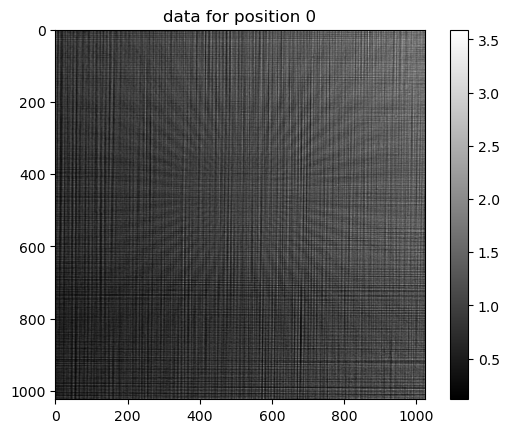

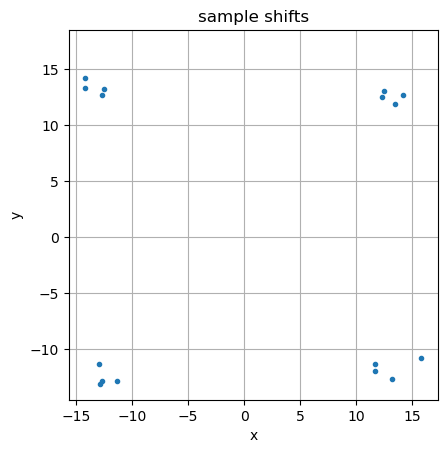

In [5]:
arr0 = data[0].get() if hasattr(data[0], "get") else xp.asarray(data[0])
plt.imshow(arr0,cmap='gray')
plt.title('data for position 0')
plt.colorbar()
plt.show()
arr0 = pos.get() if hasattr(pos, "get") else xp.asarray(pos)
plt.plot(arr0[:,1],arr0[:,0],'.')
plt.axis('square')
plt.title('sample shifts')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

# Fresnel kernel

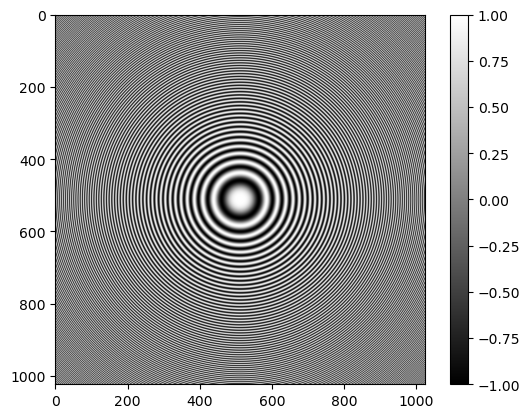

In [6]:
fx = xp.fft.fftfreq(n, d=voxelsize).astype("float32")
[fx, fy] = xp.meshgrid(fx, fx)
fker = xp.exp(-1j * xp.pi * wavelength * distance * (fx**2 + fy**2))
arr0 = xp.fft.fftshift(fker).real
arr0 = arr0.get() if hasattr(arr0, "get") else xp.asarray(arr0)
plt.imshow(arr0,cmap='gray')
plt.colorbar()

## Fresnel transform and shift operators

In [7]:
def D(obj):
    """Forward propagator"""
    return xp.fft.ifft2(xp.fft.fft2(obj) * fker)    

def DT(obj):
    """Adjoint propagator"""
    return xp.fft.ifft2(xp.fft.fft2(obj) / fker)    

def S(obj, r):
    """Shift operator"""
    # shift via swithicng to frequencies
    x = xp.fft.fftfreq(nobj).astype("float32")
    [y, x] = xp.meshgrid(x, x)
    r = r[...,None,None]
    tmp = xp.exp(-2 * xp.pi * 1j * (y * r[:, 1] + x * r[:, 0])).astype("complex64")
    sobj = xp.fft.ifft2(tmp * xp.fft.fft2(obj[None]))

    # crop to the detector size
    pad = nobj//2-n//2
    sobj = sobj[:,pad:-pad,pad:-pad]
    return sobj

def ST(obj, r):
    """Adjoint shift operator"""
    # pad with 0
    pad = nobj//2-n//2
    sobj = xp.pad(obj,((0,0),(pad,pad),(pad,pad)))
    
    # shift via swithicng to frequencies
    x = xp.fft.fftfreq(nobj).astype("float32")
    [y, x] = xp.meshgrid(x, x)
    r = r[...,None,None]
    tmp = xp.exp(2 * xp.pi * 1j * (y * r[:, 1] + x * r[:, 0])).astype("complex64")
    sobj = xp.sum(xp.fft.ifft2(tmp * xp.fft.fft2(sobj)),axis=0)    
    return sobj

## Operators, and their differentials
##### $F_0\circ F_1 (obj,prb)=\Big\||D(prb\cdot S_r(obj))|-d\Big\|^2_2$,
##### where
##### $F_0(x)=\Big\||x|-d\Big\|^2_2$
##### $F_1(x_{11},x_{12})=D(x_{11}\cdot S_r(x_{12}))$


In [8]:
def reprod(a, b):
    return a.real * b.real + a.imag * b.imag

def redot(a, b):
    res = xp.sum(reprod(a, b))
    return res

def F0(x, d):
    """Functional"""
    return xp.linalg.norm(xp.abs(x) - d) ** 2 

def F1(x):
    """Functional"""
    x11, x12 = x
    x0 = D(x11 * S(x12,pos))    
    return x0

def dF0(x, y, d):
    """First order term"""    
    tmp = x - d * x / xp.abs(x)
    return 2*redot(tmp, y)

def dF1(x, y):
    """First order term"""
    x11, x12 = x
    y11, y12 = y
    y0 = D(y11 * S(x12,pos) + x11 * S(y12,pos))    
    return y0

def d2F0(x, y, z, d):
    """Second order term"""
    
    l0 = x / xp.abs(x)
    d0 = d / xp.abs(x)
    v1 = xp.sum((1 - d0) * reprod(y, z))
    v2 = xp.sum(d0 * reprod(l0, y) * reprod(l0, z))
    return 2 * (v1 + v2)

def d2F1(x, y, z):
    """Second order term"""
    y11, y12 = y
    z11, z12 = z

    if y12 is z12:
        y0 = 2 * D(y11 * S(y12, pos))
    else:
        y0 = D(y11 * S(z12, pos)) + D(z11 * S(y12, pos))

    return y0

def gF0(x, y):
    """Gradient"""        
    # calc fwd 
    x = F1(x)
    td = y * x / xp.abs(x)
    y0 = 2  * (x - td) 
    return y0

def gF1(x, y):
    """Gradient"""
    y0 = y        
    x11, x12 = x                
    tmp = DT(y0)  
    y11 = xp.sum(tmp* xp.conj(S(x12,pos)), axis=0)
    y12 = ST(tmp * xp.conj(x11),pos)
    return y11, y12   

### Bilinear Hessian solver

In [9]:
def gradients(x,data):
    """Gradient via the Cascade rule"""
    return gF1(x,gF0(x,data))

def hessian(x,y,z,data):
    """Hessian via the Cascade rule"""
    Fx = F1(x)
    v1 = d2F0(Fx,dF1(x,y),dF1(x,z),data)
    v2 = dF0(Fx,d2F1(x,y,z),data)
    return v1+v2

def min(x,data):
    return F0(F1(x),data)

def BH(data, x, niter = 1):
    data = xp.sqrt(data)
    rho_sq = [4, 1]
    print(f'i err: {min(x,data):.3e}')
        
    for i in range(niter):    
        # gradients for each variable
        y = gradients(x,data)
        y = [yk*rho_sqk for yk,rho_sqk in zip(y,rho_sq)]
        if i == 0:
            z = [-yk for yk in y]
        else:
            # conjugate direction
            beta = hessian(x,y,z, data)/hessian(x,z,z, data)            
            # update each variable
            z[:] = [-yk + beta*zk for yk, zk in zip(y, z)]
            
        # step length
        top = sum(-redot(yk, zk)/rho_sqk for yk, zk, rho_sqk in zip(y,z,rho_sq))
        bottom = hessian(x,z,z, data)            
        alpha = top/bottom
        
        # update variables
        x[:] = [xk + alpha*zk for xk, zk in zip(x, z)]

        # show error        
        if i%10==0:        
            print(f'{i} err: {min(x,data):.3e}')
    return x


### Run reconstruction 


i err: 6.112e+05
0 err: 1.095e+04
10 err: 9.361e+02
20 err: 7.095e+02
30 err: 5.542e+02
40 err: 4.387e+02
50 err: 3.575e+02
60 err: 3.002e+02
70 err: 2.598e+02
80 err: 2.300e+02
90 err: 2.073e+02


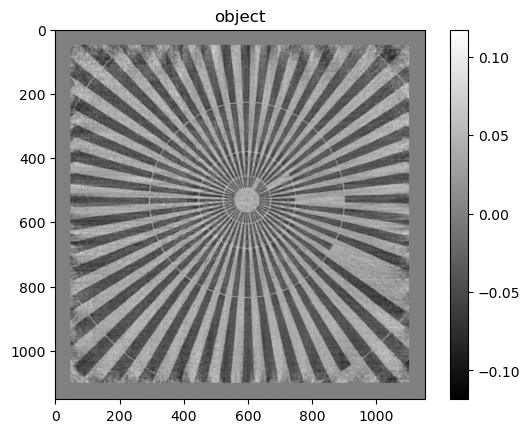

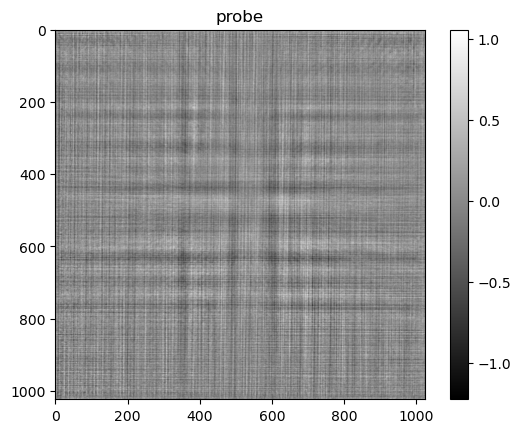

In [10]:
# initial guess
rec_obj = xp.ones([nobj,nobj],dtype='complex64')
rec_prb = xp.ones([n,n],dtype='complex64')

# run
rec_prb,rec_obj = BH(data, [rec_prb, rec_obj], niter=100)

#show result
arr0 = xp.angle(rec_obj)
arr0 = arr0.get() if hasattr(arr0, "get") else xp.asarray(arr0)
plt.imshow(arr0,cmap='gray')
plt.colorbar()
plt.title('object')
plt.show()

arr0 = xp.angle(rec_prb)
arr0 = arr0.get() if hasattr(arr0, "get") else xp.asarray(arr0)
plt.imshow(arr0,cmap='gray')
plt.colorbar()
plt.title('probe')
plt.show()